In [1]:
import pandas as pd
import pandas_datareader.data as web
import sklearn.mixture as mix

import numpy as np
import scipy.stats as scs

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline

import seaborn as sns
import missingno as msno
from tqdm import tqdm
p=print

            TEDRATE  T10Y2Y  T10Y3M        SPY      sret
2002-01-02     0.15    1.98    3.46  82.057861  0.010703
2002-01-03     0.18    1.97    3.43  82.988342  0.011276
2002-01-04     0.18    1.99    3.46  83.542381  0.006654
2002-01-07     0.21    2.01    3.41  82.952843 -0.007082
2002-01-08     0.19    2.03    3.42  82.761070 -0.002315


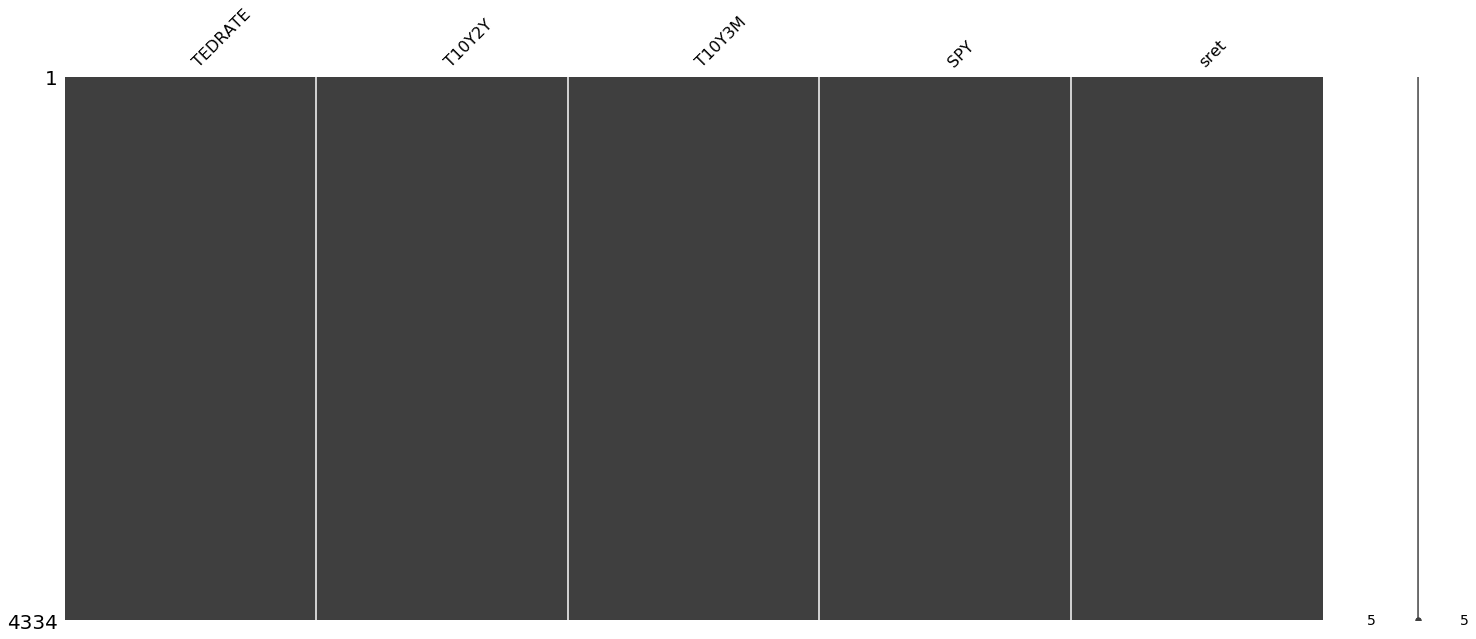

In [3]:
# get fed data
#需要vpn
f1 = 'TEDRATE' # ted spread
f2 = 'T10Y2Y' # constant maturity ten yer - 2 year
f3 = 'T10Y3M' # constant maturity 10yr - 3m

start = pd.to_datetime('2002-01-01')
end = pd.datetime.today()

mkt = 'SPY'
MKT = (web.DataReader([mkt], 'yahoo', start, end)['Adj Close']
       .rename(columns={mkt:mkt})
       .assign(sret=lambda x: np.log(x[mkt]/x[mkt].shift(1)))
       .dropna())

data = (web.DataReader([f1, f2, f3], 'fred', start, end)
        .join(MKT, how='inner')
        .dropna()
       )

p(data.head())

# gives us a quick visual inspection of the data
msno.matrix(data)

In [5]:
MKT.head()

Symbols,SPY,sret
Date,,
2002-01-02,82.057861,0.010703
2002-01-03,82.988342,0.011276
2002-01-04,83.542381,0.006654
2002-01-07,82.952843,-0.007082
2002-01-08,82.761070,-0.002315


In [6]:
data.head()

,TEDRATE,T10Y2Y,T10Y3M,SPY,sret
2002-01-02,0.15,1.98,3.46,82.057861,0.010703
2002-01-03,0.18,1.97,3.43,82.988342,0.011276
2002-01-04,0.18,1.99,3.46,83.542381,0.006654
2002-01-07,0.21,2.01,3.41,82.952843,-0.007082
2002-01-08,0.19,2.03,3.42,82.761070,-0.002315


#### the observable variables I use are: the underlying asset returns, the Ted Spread, the 10 year - 2 year constant maturity spread, and the 10 year - 3 month constant maturity spread.

In [8]:
col = 'sret'
print(len(data))
select = data.dropna()
print(len(select))

4334
4334


In [9]:
ft_cols = [f1, f2, f3, 'sret']
X = select[ft_cols].values

In [10]:
model = mix.GaussianMixture(n_components=3, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)

In [11]:
# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

In [12]:
print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))
    print()


Means and vars of each hidden state
0th hidden state
mean =  [ 9.71903365e-01  1.61191346e+00  2.27137181e+00 -1.51993863e-03]
var =  [5.51585180e-01 3.13581975e-01 9.07325422e-01 4.37586255e-04]

1th hidden state
mean =  [0.40882798 0.11985153 0.21954295 0.00071208]
var =  [2.03458828e-02 2.60830204e-02 2.28090304e-01 5.18864735e-05]

2th hidden state
mean =  [2.66748713e-01 1.76723132e+00 2.30256492e+00 5.84213720e-04]
var =  [9.28941514e-03 4.52960731e-01 5.70014467e-01 7.51265344e-05]



In [18]:
sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3
              , 'legend.frameon': True}
sns.set_style('white', style_kwds)


In [19]:
hidden_states

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

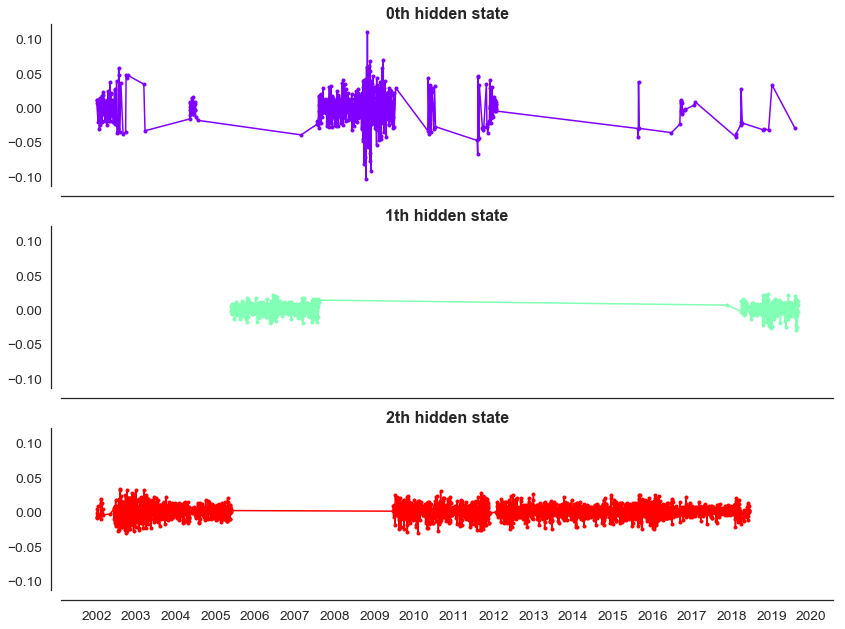

In [20]:
fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(select.index.values[mask],
                 select[col].values[mask],
                 ".-", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)

plt.tight_layout()
fig.savefig('Hidden Markov (Mixture) Model_Regime Subplots.png')

        Date  states  TEDRATE  T10Y2Y  T10Y3M        SPY      sret  mkt_cret
0 2002-01-02       0     0.15    1.98    3.46  82.057861  0.010703  0.010703
1 2002-01-03       0     0.18    1.97    3.43  82.988342  0.011276  0.021979
2 2002-01-04       0     0.18    1.99    3.46  83.542381  0.006654  0.028633
3 2002-01-07       2     0.21    2.01    3.41  82.952843 -0.007082  0.021551
4 2002-01-08       2     0.19    2.03    3.42  82.761070 -0.002315  0.019236


D:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


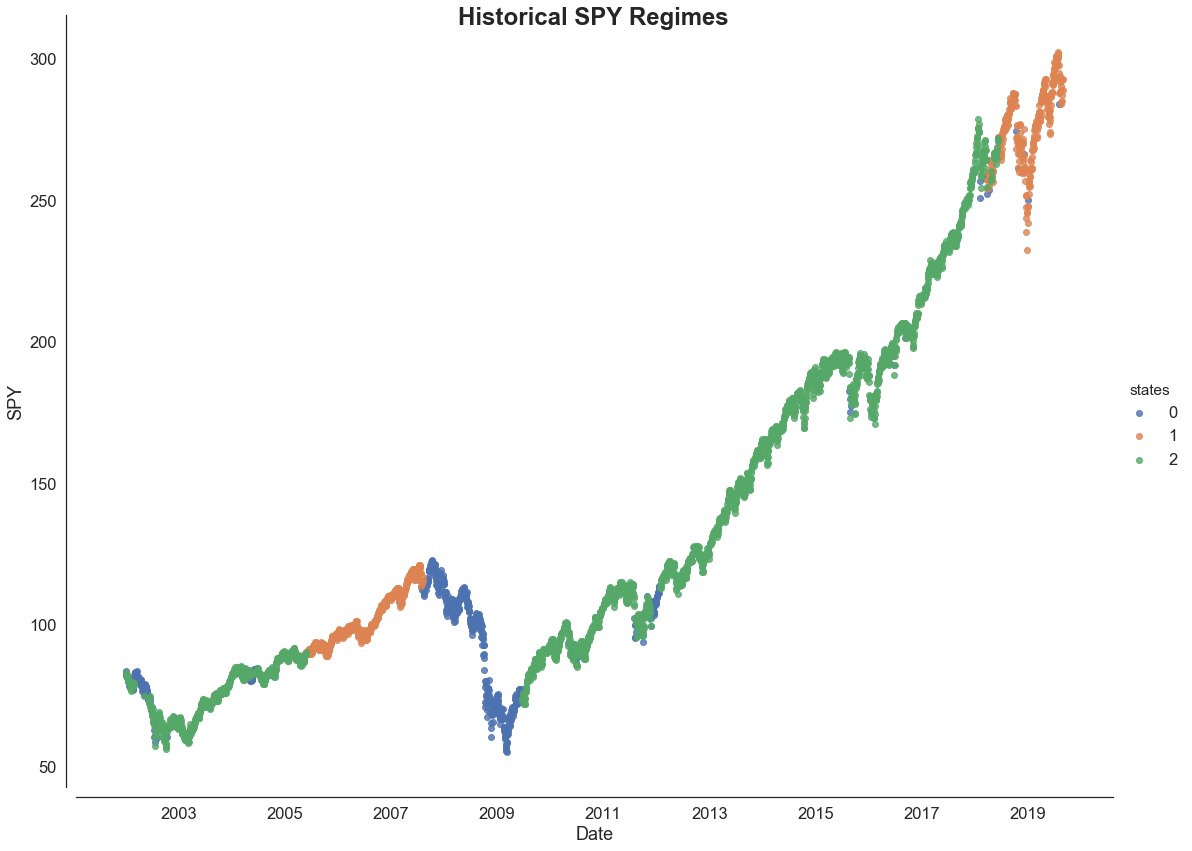

In [21]:
sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states, columns=['states'], index=select.index)
          .join(select, how='inner')
          .assign(mkt_cret=select.sret.cumsum())
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
p(states.head())

sns.set_style('white', style_kwds)
order = [0, 1, 2]
fg = sns.FacetGrid(data=states, hue='states', hue_order=order,
                    aspect=1.31, size=12)
fg.map(plt.scatter, 'Date', mkt, alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Historical SPY Regimes', fontsize=24, fontweight='demi')
fg.savefig('Hidden Markov (Mixture) Model_SPY Regimes.png')